In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import theano, theano.tensor as T
theano.config.floatX='float32'
import lasagne, lasagne.layers as L
import os
from librosa import load, logamplitude
from librosa.feature import melspectrogram
from tqdm import tqdm_notebook
from multiprocessing import Pool
import pickle
from scipy.io.wavfile import read, write

In [2]:
midi_one_clear = pickle.load(open("./DATA/s1mc/d", "rb"))
midi_one_clear_names = [midi_one_clear[i][0] for i in range(len(midi_one_clear))]
midi_one_clear_specs = np.asarray([midi_one_clear[i][1][:, :174] for i in range(len(midi_one_clear))])

midi_one_noised = pickle.load(open("./DATA/s1mn/d", "rb"))
midi_one_noised_names = [midi_one_noised[i][0] for i in range(len(midi_one_noised))]
midi_one_noised_specs = np.asarray([midi_one_noised[i][1][:, :174] for i in range(len(midi_one_noised))])

real_one_clear = pickle.load(open("./DATA/s1rc/d", "rb"))
real_one_clear_names = [real_one_clear[i][0] for i in range(len(real_one_clear))]
real_one_clear_specs = np.asarray([real_one_clear[i][1][:, :174] for i in range(len(real_one_clear))])

real_one_noised = pickle.load(open("./DATA/s1rn/d", "rb"))
real_one_noised_names = [real_one_noised[i][0] for i in range(len(real_one_noised))]
real_one_noised_specs = np.asarray([real_one_noised[i][1][:, :174]for i in range(len(real_one_noised))])

real_one_clear_2 = pickle.load(open("./DATA/s1rc2/d", "rb"))
real_one_clear_names_2 = [real_one_clear_2[i][0] for i in range(len(real_one_clear_2))]
real_one_clear_specs_2 = np.asarray([real_one_clear_2[i][1][:, :174] for i in range(len(real_one_clear_2))])

signal_one_clear = pickle.load(open("./DATA/s1sc/d", "rb"))
signal_one_clear_names = [signal_one_clear[i][0] for i in range(len(signal_one_clear))]
signal_one_clear_specs = np.asarray([signal_one_clear[i][1][:, :174] for i in range(len(signal_one_clear))])

In [3]:
# for i in tqdm_notebook(os.listdir("./DATA/snmc/")):
#     spec = pickle.load(open("./DATA/snmc/" + i, "rb"))
#     specs = np.asarray([spec[i][1][:, :44] for i in range(len(spec))])
#     specs = np.asarray([np.concatenate((specs[i], specs[i], specs[i], specs[i]), axis = 1)[:, :174] 
#                     for i in range(len(specs))])
    
#     spec_names = [spec[i][0] for i in range(len(spec))]
#     spec_names = [i.split("|")[0] for i in spec_names]
#     spec_answ = []
#     for i in range(len(spec_names)):
#         o = np.zeros(88)
#         notes = spec_names[i][:-4].split(",")
#         for i in notes:
#             o[int(i) - 21] = 1
#         spec_answ.append(o)

In [4]:
midi_one_clear_answ = []
for i in range(len(midi_one_clear_names)):
    o = np.zeros(88)
    o[int(midi_one_clear_names[i][:-4]) - 1] = 1
    midi_one_clear_answ.append(o)
    
midi_one_noised_answ = []
for i in range(len(midi_one_noised_names)):
    o = np.zeros(88)
    o[int(midi_one_noised_names[i][:-4]) - 1] = 1
    midi_one_noised_answ.append(o)
    
real_one_clear_answ = []
for i in range(len(real_one_clear_names)):
    o = np.zeros(88)
    o[int(real_one_clear_names[i][:-4]) - 1] = 1
    real_one_clear_answ.append(o)
    
real_one_noised_answ = []
for i in range(len(real_one_noised_names)):
    o = np.zeros(88)
    o[int(real_one_noised_names[i][:-4]) - 1] = 1
    real_one_noised_answ.append(o)
    
real_one_clear_answ_2 = []
for i in range(len(real_one_clear_names_2)):
    o = np.zeros(88)
    o[int(real_one_clear_names_2[i][:-4]) - 1] = 1
    real_one_clear_answ_2.append(o)
    
signal_one_clear_answ = []
for i in range(len(signal_one_clear_names)):
    o = np.zeros(88)
    o[int(signal_one_clear_names[i][:-4]) - 1] = 1
    signal_one_clear_answ.append(o)

In [5]:
X_train = np.concatenate((midi_one_clear_specs, midi_one_noised_specs, real_one_clear_specs, real_one_noised_specs, 
                          signal_one_clear_specs))
y_train = np.concatenate((midi_one_clear_answ, midi_one_noised_answ, real_one_clear_answ, real_one_noised_answ, 
                          signal_one_clear_answ))

In [30]:
X_input_conv_r = T.tensor4("Input X (for conv_r)")
y_target_conv_r = T.matrix("Target y (for conv_r)", dtype='int32')

X_input_conv_f = T.tensor4("Input X (for conv_f)")
y_target_conv_f = T.vector("Target y (for conv_f)", dtype='int32')

disc_input = T.matrix("Disc input")

In [31]:
conv_r = L.InputLayer((None, 1) + X_train.shape[1:])
print(conv_r.output_shape)
conv_r2 = L.Conv2DLayer(conv_r, 20, 3)
print(conv_r2.output_shape)
conv = L.BatchNormLayer(conv_r2)
print(conv.output_shape)
conv_r3 = L.Pool2DLayer(conv, 2)
print(conv_r3.output_shape)
conv_r4 = L.Conv2DLayer(conv_r3, 20, 3)
print(conv_r4.output_shape)
conv = L.BatchNormLayer(conv_r4)
print(conv.output_shape)
conv_r5 = L.Pool2DLayer(conv, 2)
print(conv_r5.output_shape)
conv_r_dense = L.DenseLayer(conv_r5, 200)
print(conv_r_dense.output_shape)
conv = L.DropoutLayer(conv_r_dense, p=0.1)
print(conv.output_shape)
conv_r6 = L.DenseLayer(conv, 88, nonlinearity=T.nnet.sigmoid)
print(conv_r6.output_shape)

(None, 1, 150, 174)
(None, 20, 148, 172)
(None, 20, 148, 172)
(None, 20, 74, 86)
(None, 20, 72, 84)
(None, 20, 72, 84)
(None, 20, 36, 42)
(None, 200)
(None, 200)
(None, 88)


In [32]:
disc = L.InputLayer(conv_r_dense.output_shape)
print(disc.output_shape)
disc = L.DenseLayer(disc, 100, nonlinearity=T.nnet.elu)
print(disc.output_shape)
# disc = L.DropoutLayer(disc, p=0.1)
disc = L.DenseLayer(disc, 50, nonlinearity=T.nnet.elu)
print(disc.output_shape)
disc = L.DenseLayer(disc, 1, nonlinearity=T.nnet.sigmoid)
print(disc.output_shape)

(None, 200)
(None, 100)
(None, 50)
(None, 1)


In [33]:
y_predicted_conv_r = lasagne.layers.get_output(conv_r6, X_input_conv_r)
y_predicted_conv_r_det = lasagne.layers.get_output(conv_r6, X_input_conv_r, deterministic=True)

y_predicted_conv_f_dense = lasagne.layers.get_output(conv_r_dense, X_input_conv_f)
y_predicted_disc = lasagne.layers.get_output(disc, y_predicted_conv_f_dense)
y_predicted_conv_f_dense_det = lasagne.layers.get_output(conv_r_dense, X_input_conv_f, deterministic=True)
y_predicted_disc_det = lasagne.layers.get_output(disc, y_predicted_conv_f_dense, deterministic=True)

In [34]:
# loss for discriminator: P(real | x real) -> 1, P(real | x fake) -> 0
disc_loss = lasagne.objectives.binary_crossentropy(y_predicted_disc, y_target_conv_f).mean()

# loss for generator: increase P(real | x fake) and  decrease P(real | x real) OVER GENERATOR PARAMS
adv_loss = lasagne.objectives.binary_crossentropy(y_predicted_disc, 1-y_target_conv_f).mean()

conv_r_loss_dense = lasagne.objectives.binary_crossentropy(y_predicted_conv_r, y_target_conv_r).mean()
conv_r_loss_last = conv_r_loss_dense + adv_loss*0.005

In [35]:
disc_acc = lasagne.objectives.binary_accuracy(y_predicted_disc_det, y_target_conv_f).mean()
conv_r_acc = lasagne.objectives.categorical_accuracy(y_predicted_conv_r_det, y_target_conv_r).mean()

In [36]:
disc_weights = lasagne.layers.get_all_params(disc, trainable=True)
disc_updates_adam = lasagne.updates.adam(disc_loss, disc_weights)

conv_r_last_weights = lasagne.layers.get_all_params(conv_r6, trainable=True)
conv_r_last_updates_adam = lasagne.updates.adam(conv_r_loss_last, conv_r_last_weights)

In [37]:
train_r = theano.function([X_input_conv_r, y_target_conv_r, X_input_conv_f, y_target_conv_f], 
                          [conv_r_loss_dense, adv_loss], updates=conv_r_last_updates_adam, allow_input_downcast=True)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '27988' (I am process '31476')


In [38]:
train_f = theano.function([X_input_conv_f, y_target_conv_f], disc_loss, updates=disc_updates_adam, allow_input_downcast=True)   

In [39]:
eval_disc = theano.function([X_input_conv_f, y_target_conv_f], disc_acc, allow_input_downcast=True)

In [40]:
eval_conv_r = theano.function([X_input_conv_r, y_target_conv_r], conv_r_acc, allow_input_downcast=True)

In [41]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [42]:
train_r(X_train[:10,None], y_train[:10], X_train[:10,None], np.zeros(len(X_train))[:10])

[array(1.194109728581944), array(0.8788957864046096)]

In [43]:
print("Disc accuracy:", eval_disc(X_train[:10,None], np.zeros(10)))
print("Conv accuracy:", eval_conv_r(X_train[:10, None], y_train[:10]))

Disc accuracy: 1.0
Conv accuracy: 0.1


In [44]:
specs_midi_clear_names = os.listdir("./DATA/snmc/")
specs_midi_noised_names = os.listdir("./DATA/snmn/")

In [45]:
def get_data(x):
    data = pickle.load(open(x, "rb"))
    names = [data[i][0] for i in range(len(data))]
    names = [i.split("|")[0] for i in names]
    specs = np.asarray([data[i][1][:, :44] for i in range(len(data))])
    specs = np.asarray([np.concatenate((specs[i], specs[i], specs[i], specs[i]), axis = 1)[:, :174] 
                    for i in range(len(specs))])
    
    answ = []
    for i in range(len(names)):
        o = np.zeros(88)
        for i in names[i][:-4].split(","):
            o[int(i) - 21] = 1
        answ.append(o)
    return specs, answ

In [46]:
disc_accs = []
conv_accs = []
neg_conv_accs = []

In [47]:
test_noised_spec, test_noised_answ = get_data("./test_noised")

In [48]:
test_clear_spec, test_clear_answ = get_data("./test_clear")

In [49]:
batchsize=100

for epoch in tqdm_notebook(range(250)):
    
    spec_midi_chords_clear, answ_midi_chords_clear = get_data("./DATA/snmc/" + 
                                                        specs_midi_clear_names[epoch % len(specs_midi_clear_names)])
    spec_midi_chords_noised, answ_midi_chords_noised = get_data("./DATA/snmn/" + 
                                                        specs_midi_noised_names[epoch % len(specs_midi_noised_names)])
    
    x_tr_gen = np.concatenate((spec_midi_chords_clear, X_train))
    y_tr_gen = np.concatenate((answ_midi_chords_clear, y_train))
    
    x_tr_real = np.concatenate((spec_midi_chords_noised, real_one_clear_specs_2, x_tr_gen))
    y_tr_real = np.concatenate((np.ones(len(answ_midi_chords_clear) + len(real_one_clear_answ_2)),
                                np.zeros(len(x_tr_gen))))
    y_tr_real_answ = np.concatenate((answ_midi_chords_noised, real_one_clear_answ_2, y_tr_gen))
    
    indexes = np.arange(len(x_tr_real))
    np.random.shuffle(indexes)
    x_tr_real = [x_tr_real[i] for i in indexes]
    y_tr_real = [y_tr_real[i] for i in indexes]
    y_tr_real_answ = [y_tr_real_answ[i] for i in indexes]
    
    for n, (x_batch,y_batch) in enumerate(iterate_minibatches(x_tr_gen,y_tr_gen,batchsize,shuffle=True)):
        if x_tr_real[n*batchsize : (n+1)*batchsize] == []:
            break
        if n%2 == 0:
            train_r(np.asarray(x_batch)[:,None], y_batch, np.asarray(x_tr_real[n*batchsize : (n+1)*batchsize])[:,None], y_tr_real[n*batchsize : (n+1)*batchsize])   
        train_f(np.asarray(x_tr_real[n*batchsize : (n+1)*batchsize])[:, None], y_tr_real[n*batchsize : (n+1)*batchsize])
        
    print("Epoch",epoch)
    disc_accs.append(eval_disc(np.asarray(test_noised_spec)[:len(x_tr_gen)//100,None],np.ones(len(x_tr_gen)//100)))
    print("Disc accuracy:", disc_accs[-1])
    conv_accs.append(eval_conv_r(np.asarray(test_clear_spec)[:len(x_tr_gen)//100,None], test_clear_answ[:len(x_tr_gen)//100]))
    print("Conv accuracy:", conv_accs[-1])
    neg_conv_accs.append(eval_conv_r(np.asarray(test_noised_spec)[:len(x_tr_gen)//100,None], test_noised_answ[:len(x_tr_gen)//100]))
    print("Negative accuracy:", neg_conv_accs[-1])    

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"

  0%|          | 0/13 [00:00<?, ?it/s]
Exception in thread Thread-34:
Traceback (most recent call last):
  File "/home/alena/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/alena/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/alena/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 13/13 [01:21<00:00,  6.34s/it]


Epoch 0
Disc accuracy: 0.0
Conv accuracy: 0.0
Negative accuracy: 0.0


100%|██████████| 13/13 [01:16<00:00,  6.29s/it]      | 1/13 [00:09<01:55,  9.60s/it]


Epoch 1
Disc accuracy: 0.07692307692307693
Conv accuracy: 0.07692307692307693
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:15<00:00,  6.30s/it]      | 1/13 [00:09<01:56,  9.72s/it]


Epoch 2
Disc accuracy: 0.38461538461538464
Conv accuracy: 0.07692307692307693
Negative accuracy: 0.0


100%|██████████| 13/13 [01:15<00:00,  6.15s/it]      | 1/13 [00:09<01:54,  9.55s/it]


Epoch 3
Disc accuracy: 0.07692307692307693
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:14<00:00,  6.12s/it]      | 1/13 [00:09<01:52,  9.37s/it]


Epoch 4
Disc accuracy: 0.5384615384615384
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:17<00:00,  6.64s/it]      | 1/13 [00:09<01:53,  9.46s/it]


Epoch 5
Disc accuracy: 0.23076923076923078
Conv accuracy: 0.15384615384615385
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:14<00:00,  6.09s/it]      | 1/13 [00:09<01:53,  9.43s/it]


Epoch 6
Disc accuracy: 0.23076923076923078
Conv accuracy: 0.23076923076923078
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:13<00:00,  6.09s/it]      | 1/13 [00:09<01:52,  9.37s/it]


Epoch 7
Disc accuracy: 0.07692307692307693
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:13<00:00,  6.12s/it]      | 1/13 [00:09<01:51,  9.29s/it]


Epoch 8
Disc accuracy: 0.3076923076923077
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:13<00:00,  6.10s/it]      | 1/13 [00:09<01:55,  9.64s/it]


Epoch 9
Disc accuracy: 0.6153846153846154
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.3076923076923077


100%|██████████| 13/13 [01:14<00:00,  6.16s/it]      | 1/13 [00:09<01:52,  9.38s/it]


Epoch 10
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:14<00:00,  6.28s/it]      | 1/13 [00:09<01:52,  9.40s/it]


Epoch 11
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:16<00:00,  6.17s/it]      | 1/13 [00:10<02:04, 10.35s/it]


Epoch 12
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.0


100%|██████████| 13/13 [01:15<00:00,  6.26s/it]      | 1/13 [00:10<02:03, 10.33s/it]


Epoch 13
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:13<00:00,  6.06s/it]      | 1/13 [00:09<01:59,  9.94s/it]


Epoch 14
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:12<00:00,  5.99s/it]      | 1/13 [00:09<01:51,  9.32s/it]


Epoch 15
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:11<00:00,  5.94s/it]      | 1/13 [00:09<01:50,  9.23s/it]


Epoch 16
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.23076923076923078
Negative accuracy: 0.0


100%|██████████| 13/13 [01:12<00:00,  5.98s/it]      | 1/13 [00:09<01:50,  9.21s/it]


Epoch 17
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:12<00:00,  5.99s/it]      | 1/13 [00:09<01:52,  9.36s/it]


Epoch 18
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:11<00:00,  5.92s/it]      | 1/13 [00:09<01:49,  9.14s/it]


Epoch 19
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:12<00:00,  5.97s/it]      | 1/13 [00:09<01:49,  9.14s/it]


Epoch 20
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:11<00:00,  5.94s/it]      | 1/13 [00:09<01:49,  9.16s/it]


Epoch 21
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:12<00:00,  5.96s/it]      | 1/13 [00:09<01:50,  9.24s/it]


Epoch 22
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.0


100%|██████████| 13/13 [01:12<00:00,  6.09s/it]      | 1/13 [00:09<01:49,  9.15s/it]


Epoch 23
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:13<00:00,  6.09s/it]      | 1/13 [00:09<01:53,  9.49s/it]


Epoch 24
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:14<00:00,  6.23s/it]      | 1/13 [00:09<01:53,  9.43s/it]


Epoch 25
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:16<00:00,  6.30s/it]      | 1/13 [00:11<02:18, 11.54s/it]


Epoch 26
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:14<00:00,  6.20s/it]      | 1/13 [00:09<01:52,  9.34s/it]


Epoch 27
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:14<00:00,  6.09s/it]      | 1/13 [00:09<01:58,  9.85s/it]


Epoch 28
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:16<00:00,  6.12s/it]      | 1/13 [00:11<02:13, 11.17s/it]


Epoch 29
Disc accuracy: 0.9230769230769231
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:24<00:00,  6.43s/it]      | 1/13 [00:12<02:24, 12.06s/it]


Epoch 30
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:16<00:00,  6.47s/it]      | 1/13 [00:09<01:51,  9.27s/it]


Epoch 31
Disc accuracy: 0.6153846153846154
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:26<00:00,  7.72s/it]      | 1/13 [00:10<02:07, 10.65s/it]


Epoch 32
Disc accuracy: 0.6153846153846154
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:24<00:00,  7.20s/it]      | 1/13 [00:10<02:08, 10.68s/it]


Epoch 33
Disc accuracy: 0.6153846153846154
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:19<00:00,  6.28s/it]      | 1/13 [00:10<02:09, 10.76s/it]


Epoch 34
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:22<00:00,  6.52s/it]      | 1/13 [00:11<02:12, 11.01s/it]


Epoch 35
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:19<00:00,  6.11s/it]      | 1/13 [00:10<02:07, 10.62s/it]


Epoch 36
Disc accuracy: 0.8461538461538461
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:12<00:00,  5.99s/it]      | 1/13 [00:09<01:52,  9.39s/it]


Epoch 37
Disc accuracy: 0.7692307692307693
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:12<00:00,  5.98s/it]      | 1/13 [00:09<01:53,  9.48s/it]


Epoch 38
Disc accuracy: 0.6923076923076923
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.23076923076923078


100%|██████████| 13/13 [01:12<00:00,  5.97s/it]      | 1/13 [00:09<01:51,  9.30s/it]


Epoch 39
Disc accuracy: 0.5384615384615384
Conv accuracy: 0.23076923076923078
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:17<00:00,  7.16s/it]      | 1/13 [00:09<01:52,  9.34s/it]


Epoch 40
Disc accuracy: 0.38461538461538464
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:25<00:00,  6.55s/it]      | 1/13 [00:12<02:31, 12.59s/it]


Epoch 41
Disc accuracy: 0.46153846153846156
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:23<00:00,  7.05s/it]      | 1/13 [00:10<02:05, 10.50s/it]


Epoch 42
Disc accuracy: 0.38461538461538464
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:26<00:00,  7.53s/it]      | 1/13 [00:10<02:05, 10.48s/it]


Epoch 43
Disc accuracy: 0.46153846153846156
Conv accuracy: 0.5384615384615384
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:19<00:00,  6.27s/it]      | 1/13 [00:12<02:29, 12.48s/it]


Epoch 44
Disc accuracy: 0.6153846153846154
Conv accuracy: 0.46153846153846156
Negative accuracy: 0.15384615384615385


100%|██████████| 13/13 [01:17<00:00,  6.27s/it]      | 1/13 [00:09<01:54,  9.55s/it]


Epoch 45
Disc accuracy: 0.5384615384615384
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:27<00:00,  6.71s/it]      | 1/13 [00:12<02:27, 12.27s/it]


Epoch 46
Disc accuracy: 0.38461538461538464
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:23<00:00,  6.93s/it]      | 1/13 [00:11<02:21, 11.75s/it]


Epoch 47
Disc accuracy: 0.38461538461538464
Conv accuracy: 0.23076923076923078
Negative accuracy: 0.0


100%|██████████| 13/13 [01:25<00:00,  6.76s/it]      | 1/13 [00:11<02:23, 12.00s/it]


Epoch 48
Disc accuracy: 0.46153846153846156
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:14<00:00,  6.05s/it]      | 1/13 [00:10<02:03, 10.26s/it]


Epoch 49
Disc accuracy: 0.5384615384615384
Conv accuracy: 0.3076923076923077
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:13<00:00,  6.01s/it]      | 1/13 [00:09<01:54,  9.56s/it]


Epoch 50
Disc accuracy: 0.5384615384615384
Conv accuracy: 0.23076923076923078
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:13<00:00,  6.04s/it]      | 1/13 [00:09<01:52,  9.39s/it]


Epoch 51
Disc accuracy: 0.6153846153846154
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.07692307692307693


100%|██████████| 13/13 [01:13<00:00,  6.06s/it]      | 1/13 [00:09<01:53,  9.42s/it]


Epoch 52
Disc accuracy: 0.46153846153846156
Conv accuracy: 0.38461538461538464
Negative accuracy: 0.23076923076923078


 77%|███████▋  | 10/13 [00:56<00:15,  5.21s/it]      | 1/13 [00:09<01:52,  9.35s/it]

KeyboardInterrupt: 

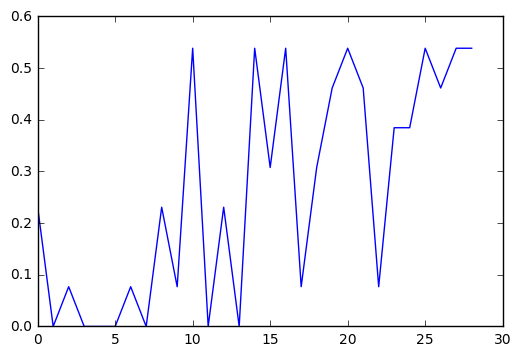

In [27]:
plt.plot(range(len(disc_accs)), disc_accs)

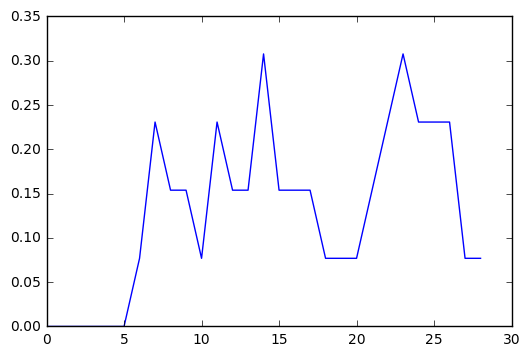

In [28]:
plt.plot(range(len(neg_conv_accs)), neg_conv_accs)

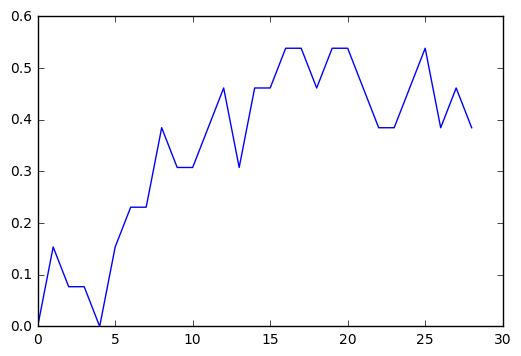

In [29]:
plt.plot(range(len(conv_accs)), conv_accs)